# Obtain a polygon shapefile corresponding to a given path and row of ALOS PALSAR 1 data. This can be be used for subsetting GEDI LIDAR data, which can be used as an input for the Forest Stand Height algorithm (https://github.com/leiyangleon/FSH)


In [8]:
#bookkeeping

import fiona #to export shapefile easily
from fiona.crs import from_epsg
{'init': 'epsg:4326', 'no_defs': True}
import pandas as pd #to read the ASF csv file having the path/row extents of ALOS1 scenes
from shapely.geometry import mapping, Point, Polygon #to create the geomoetries
import geopandas as gpd #facilitates geometry operations
from functools import reduce

# To obtain the ASF ALOS-1 scene information csv file
1. Go to https://search.asf.alaska.edu/
2. Set these settings:
    1. Search type: Geographic
    2. Dataset : ALOS PALSAR
    3. Search Filters: Additional Filters: 
        1. File Type: Level 1.0
        2. Beam Mode FBD
    4. Search Filters: Path and Frame Filters:
        1. Path Start: 142
        2. Path End: 142
        3. Frame Start: 40
        4. Frame End: 40
3. Add all results to downloads (icon just above the scene listing, cart with plus sign)
4. Click on Cart in top right corner, next to Sign In
5. Select Metadata Download, Metadata (csv)

## The downloaded CSV file will be the input for the next step.

In [9]:
#xx = pd.read_csv('asf-datapool-results-2020-06-04_02-37-17.csv')
xx = pd.read_csv('asf-datapool-results-2020-06-24_12-42-55.csv')

In [10]:
list(xx)

['Granule Name',
 'Platform',
 'Sensor',
 'Beam Mode',
 'Beam Mode Description',
 'Orbit',
 'Path Number',
 'Frame Number',
 'Acquisition Date',
 'Processing Date',
 'Processing Level',
 'Start Time',
 'End Time',
 'Center Lat',
 'Center Lon',
 'Near Start Lat',
 'Near Start Lon',
 'Far Start Lat',
 'Far Start Lon',
 'Near End Lat',
 'Near End Lon',
 'Far End Lat',
 'Far End Lon',
 'Faraday Rotation',
 'Ascending or Descending?',
 'URL',
 'Size (MB)',
 'Off Nadir Angle',
 'Stack Size',
 'Baseline Perp.',
 'Doppler',
 'GroupID']

In [11]:
#create the four corner points from the near/far start/end lon/lat values
xx['p1'] = xx.apply(lambda row: Point(row['Near Start Lon'], row['Near Start Lat']), axis = 1)
xx['p2'] = xx.apply(lambda row: Point(row['Far Start Lon'], row['Far Start Lat']), axis = 1)
xx['p3'] = xx.apply(lambda row: Point(row['Near End Lon'], row['Near End Lat']), axis = 1)
xx['p4'] = xx.apply(lambda row: Point(row['Far End Lon'], row['Far End Lat']), axis = 1)

In [12]:
#to create the polygon need to make a list of each of the points, for each row
#pl = [xx['p2'][0], xx['p1'][0], xx['p3'][0], xx['p4'][0]]
xx['pl'] = xx.apply(lambda row: [row['p2'], row['p1'], row['p3'], row['p4']], axis = 1)

In [13]:
#create a polygon from each list of corner points
xx['geometry'] = xx.apply(lambda row: Polygon([p.x, p.y] for p in row['pl']), axis = 1)

In [14]:
#write the polygon to a shapefile

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
for num, val in enumerate(xx['geometry']):
    with fiona.open(xx['Granule Name'][num]+'.shp', 'w', 'ESRI Shapefile', schema) as c:
        ## If there are multiple geometries, put the "for" loop here
        c.write({
            'geometry': mapping(val),
            'properties': {'id': 123},
    })

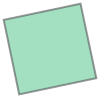

In [15]:
#use geodataframe to find intersection
gdf = gpd.GeoDataFrame(xx, geometry=xx['geometry'])
inters = reduce(Polygon.intersection, gdf.geometry)
inters

In [16]:
#write the polygon to a shapefile

# Define a polygon feature geometry with one attribute
schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Write a new Shapefile
with fiona.open('intersect.shp', 'w', crs=from_epsg(4326), driver='ESRI Shapefile', schema=schema) as c:
    ## If there are multiple geometries, put the "for" loop here
    c.write({
        'geometry': mapping(inters),
        'properties': {'id': 123},
    })